# Анализ влияния количества неплановых ремонтов на секции ранее на появление нового непланового ремонта и построение модели прогнозирования возникновение непланового ремонта в ближайший 1 день

## 1. Загрузка библиотек

In [1]:
from catboost import CatBoostClassifier, Pool
import seaborn as sns
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import plot_helper
import scipy
import datetime
from tqdm.notebook import tqdm
import glob

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from datetime import timedelta

import warnings
warnings.filterwarnings('ignore')

## 2. Загрузка данных

In [2]:
diagnostic_messages = pd.read_csv('data_for_student/1/diagnostic_messages.csv', sep=';')
unplanned_repairs = pd.read_csv('data_for_student/1/unplanned_repairs.csv', sep=';')

In [3]:
print("Первые строки набора данных 'diagnostic_message.csv':")
diagnostic_messages.head()

Первые строки набора данных 'diagnostic_message.csv':


,Unnamed: 0,SER_LOC,ZNS_LOC,PRS_LOC,START_DT,FINISH_DT,DEVICE_ID,MSG_ID,IS_CRITICAL,OPER_NAME,STATE_NAME
0,0.0,1878.0,684.0,1.0,2023-05-08T19:22:13,2023-05-08T19:27:13,1.0,5.0,0.0,Проследование поездом «нашей» станции без оста...,В голове поезда
1,1.0,1878.0,1089.0,1.0,2023-01-11T00:24:48,2023-01-11T00:29:47,3.0,10.0,1.0,Простой на станционных путях после прибытия с ...,Простой на станционных путях после прибытия с ...
2,4.0,1878.0,1015.0,1.0,2023-05-19T09:53:26,2023-05-19T09:58:18,54.0,5.0,0.0,Проследование поездом «нашей» станции без оста...,В голове поезда
3,7.0,1878.0,1676.0,0.0,2023-02-22T07:42:19,2023-02-22T07:47:10,5.0,9.0,0.0,Отправление поезда со станции (без сдачи на др...,В голове поезда
4,11.0,1878.0,708.0,1.0,2023-05-04T14:13:25,2023-05-04T14:18:24,56.0,5.0,0.0,Сдача бригадой локомотива без отцепки от поезда,В голове поезда


In [4]:
print("Первые строки набора данных 'unplanned_repairs.csv':")
unplanned_repairs.head()

Первые строки набора данных 'unplanned_repairs.csv':


,Unnamed: 0,SER_LOC,ZNS_LOC,PRS_LOC,KOD_FIRM_PRIP,KOD_FIRM_REPAIR,REPAIR_KIND,FAIL_PLACE,DATE_REPAIR_WAIT,DATE_REPAIR_BEGIN,DATE_REPAIR_FINISH
0,4,1878,1195,1,126099,66023,793,Аккумуляторная батарея,2023-10-02T07:51:00.000,2023-10-02T08:22:00.000,2023-10-02T09:04:00.000
1,15,1878,1089,0,127788,66025,793,Микропроцессорная система управления регулиров...,2023-06-05T20:53:00.000,2023-06-06T03:03:00.000,2023-06-06T04:16:00.000
2,20,1878,1089,1,127788,66025,793,Микропроцессорная система управления регулиров...,2023-06-05T20:53:00.000,2023-06-06T03:03:00.000,2023-06-06T04:16:00.000
3,30,1878,684,0,132395,132363,793,Дугогасительная камера быстродействующего выкл...,2023-10-05T11:10:00.000,2023-10-05T12:44:00.000,2023-10-05T17:03:00.000
4,42,1878,1797,0,125786,76429,793,Дугогасительная катушка быстродействующего кон...,2023-10-15T13:59:00.000,2023-10-15T13:59:00.000,2023-10-15T16:12:00.000


In [5]:
diagnostic_messages.shape, unplanned_repairs.shape

((212435, 11), (466, 11))

## 3. Подготовка данных

In [6]:
# Преобразование даты и времени в данных о локомотивах
diagnostic_messages["START_DT"] = pd.to_datetime(diagnostic_messages["START_DT"])
diagnostic_messages["FINISH_DT"] = pd.to_datetime(diagnostic_messages["FINISH_DT"])
diagnostic_messages["DURATION"] = (diagnostic_messages.FINISH_DT - diagnostic_messages.START_DT).dt.total_seconds()


# Преобразование даты и времени в данных о неплановых ремонтах
unplanned_repairs['DATE_REPAIR_WAIT'] = pd.to_datetime(unplanned_repairs['DATE_REPAIR_WAIT'])
unplanned_repairs['DATE_REPAIR_BEGIN'] = pd.to_datetime(unplanned_repairs['DATE_REPAIR_BEGIN'])
unplanned_repairs['DATE_REPAIR_FINISH'] = pd.to_datetime(unplanned_repairs['DATE_REPAIR_FINISH'])
unplanned_repairs['repair_duration'] = (unplanned_repairs['DATE_REPAIR_FINISH'] - unplanned_repairs['DATE_REPAIR_BEGIN']).dt.total_seconds()

In [7]:
diagnostic_messages.shape, diagnostic_messages.dropna().shape

((212435, 12), (206323, 12))

In [43]:
diagnostic_messages = diagnostic_messages.dropna()

In [45]:
diagnostic_messages["SER_LOC"] = diagnostic_messages.SER_LOC.astype(int)
diagnostic_messages["ZNS_LOC"] = diagnostic_messages.ZNS_LOC.astype(int)
diagnostic_messages["PRS_LOC"] = diagnostic_messages.PRS_LOC.astype(int)
diagnostic_messages["DEVICE_ID"] = diagnostic_messages.DEVICE_ID.astype(int)
diagnostic_messages["IS_CRITICAL"] = diagnostic_messages.IS_CRITICAL.astype(int)
diagnostic_messages["DURATION"] = diagnostic_messages.DURATION.astype(int)
diagnostic_messages["MSG_ID"] = diagnostic_messages.MSG_ID.astype(int)
unplanned_repairs["repair_duration"] = unplanned_repairs.repair_duration.astype(int)

### 3.1. Очистка данных

In [8]:
diagnostic_messages.drop("Unnamed: 0", axis=1, inplace=True)
unplanned_repairs.drop("Unnamed: 0", axis=1, inplace=True)

In [9]:
# определение количества пропуска в данных
print(
    "Количество ячеек со значением NAN/NULL по диагностическим сообщениям - ", 
    diagnostic_messages.isnull().sum().sum()
)

print(
    "Количество ячеек со значением NAN/NULL по неплановым ремонтам - ", 
    unplanned_repairs.isnull().sum().sum()
)

Количество ячеек со значением NAN/NULL по диагностическим сообщениям -  6947
Количество ячеек со значением NAN/NULL по неплановым ремонтам -  0


In [10]:
cols_is_null = diagnostic_messages.isnull().sum()
cols_is_null = cols_is_null[cols_is_null != 0]
cols_is_null

SER_LOC         503
ZNS_LOC         533
PRS_LOC         540
START_DT        542
FINISH_DT       603
DEVICE_ID       569
MSG_ID          534
IS_CRITICAL     543
OPER_NAME       698
STATE_NAME      739
DURATION       1143
dtype: int64

In [11]:
diagnostic_messages[~diagnostic_messages.OPER_NAME.isnull()].OPER_NAME.head()

0    Проследование поездом «нашей» станции без оста...
1    Простой на станционных путях после прибытия с ...
2    Проследование поездом «нашей» станции без оста...
3    Отправление поезда со станции (без сдачи на др...
4      Сдача бригадой локомотива без отцепки от поезда
Name: OPER_NAME, dtype: object

In [12]:
diagnostic_messages[diagnostic_messages.OPER_NAME.isnull()].shape[0] / diagnostic_messages.shape[0]

0.0032857109233412575

In [13]:
diagnostic_messages.dropna(inplace=True)

In [14]:
cols_is_null = diagnostic_messages.isnull().sum()
cols_is_null = cols_is_null[cols_is_null != 0]
cols_is_null

Series([], dtype: int64)

In [15]:
print(
    "Количество ячеек со значением NAN/NULL по диагностическим сообщениям - ", 
    diagnostic_messages.isnull().sum().sum()
)

Количество ячеек со значением NAN/NULL по диагностическим сообщениям -  0


### 3.2. Проверка данных на дубликаты

In [16]:
print(
    "Наличие дубликатов по неплановым ремонтам - ", 
    not unplanned_repairs.drop_duplicates().shape[0] == unplanned_repairs.shape[0]
)

print(
    "Наличие дубликатов по диагностическим сообщениям - ", 
    not diagnostic_messages.drop_duplicates().shape[0] == diagnostic_messages.shape[0]
)

Наличие дубликатов по неплановым ремонтам -  True
Наличие дубликатов по диагностическим сообщениям -  True


In [17]:
unplanned_repairs = unplanned_repairs.drop_duplicates()
diagnostic_messages = diagnostic_messages.drop_duplicates()

In [18]:
diagnostic_messages.shape, unplanned_repairs.shape

((191118, 11), (464, 11))

### 3.3. Объединение двух наборов данных и формирование датасета

In [19]:
uniq_msg_id = sorted(diagnostic_messages.MSG_ID.unique())
uniq_msg_id_df = pd.DataFrame(uniq_msg_id, columns=["MSG_ID"])

In [22]:
sections = set(zip(
    unplanned_repairs.SER_LOC.values, 
    unplanned_repairs.ZNS_LOC.values, 
    unplanned_repairs.PRS_LOC.values
))

In [24]:
nrs = []
without_nrs = []
for sec in tqdm(sections):
    critic_msgs = []
    nr_one_loco = unplanned_repairs[
        (unplanned_repairs.SER_LOC == sec[0])&
        (unplanned_repairs.ZNS_LOC == sec[1])&
        (unplanned_repairs.PRS_LOC == sec[2])
    ].sort_values(by="DATE_REPAIR_WAIT")
    dm_one_loco = diagnostic_messages[
        (diagnostic_messages.SER_LOC == sec[0])&
        (diagnostic_messages.ZNS_LOC == sec[1])&
        (diagnostic_messages.PRS_LOC == sec[2])
    ].sort_values(by="START_DT")
    for i in range(nr_one_loco.shape[0]):
        curr_nr = nr_one_loco.iloc[i]

        dt_1d = curr_nr.DATE_REPAIR_WAIT - timedelta(days=1)
        dt_7d = curr_nr.DATE_REPAIR_WAIT - timedelta(days=7)
        dt_14d = curr_nr.DATE_REPAIR_WAIT - timedelta(days=14)
        dt_30d = curr_nr.DATE_REPAIR_WAIT - timedelta(days=30)
        
        # подсчет критических сообщений 
        cnt_critic_diag_1d = dm_one_loco[
            (dm_one_loco.START_DT >= dt_1d)&(dm_one_loco.START_DT < curr_nr.DATE_REPAIR_WAIT)&
            (dm_one_loco.IS_CRITICAL==1)
        ].shape[0]
        
        cnt_critic_diag_7d = dm_one_loco[
            (dm_one_loco.START_DT >= dt_7d)&(dm_one_loco.START_DT < curr_nr.DATE_REPAIR_WAIT)&
            (dm_one_loco.IS_CRITICAL==1)
        ].shape[0]
        
        cnt_critic_diag_14d = dm_one_loco[
            (dm_one_loco.START_DT >= dt_14d)&(dm_one_loco.START_DT < curr_nr.DATE_REPAIR_WAIT)&
            (dm_one_loco.IS_CRITICAL==1)
        ].shape[0]
        
        cnt_critic_diag_30d = dm_one_loco[
            (dm_one_loco.START_DT >= dt_30d)&(dm_one_loco.START_DT < curr_nr.DATE_REPAIR_WAIT)&
            (dm_one_loco.IS_CRITICAL==1)
        ].shape[0]

        
        cnt_diag_30d = dm_one_loco[
            (dm_one_loco.START_DT >= dt_30d)&
            (dm_one_loco.START_DT < curr_nr.DATE_REPAIR_WAIT)
        ]
        df_msg_id = cnt_diag_30d.MSG_ID.value_counts().reset_index()
        cnt_msg = uniq_msg_id_df.merge(df_msg_id, how="left").fillna(0)["count"].values.tolist()
        
        critic_msgs.append(
            (
                sec[0], sec[1], sec[2],
                curr_nr.DATE_REPAIR_WAIT, 
                cnt_critic_diag_1d, 
                cnt_critic_diag_7d, 
                cnt_critic_diag_14d,
                cnt_critic_diag_30d,
                *cnt_msg,
                1
            )
        )
    nrs.extend(critic_msgs)
    
    general_msgs = []
    uniq_dts = dm_one_loco.START_DT.values
    for i in range(1000):
        if uniq_dts.shape[0] == 0:
            break
        rnd_dt = np.random.choice(uniq_dts)
        uniq_dts = uniq_dts[uniq_dts != rnd_dt]
        
        random_dt = pd.to_datetime(rnd_dt)
        future_dt = pd.to_datetime(random_dt) + timedelta(days=30)
        check_df = nr_one_loco[
            (nr_one_loco.DATE_REPAIR_WAIT >= random_dt)&
            (nr_one_loco.DATE_REPAIR_WAIT < future_dt)
        ]
        if check_df.shape[0] == 0:
            dt_1d = future_dt - timedelta(days=1)
            dt_7d = future_dt - timedelta(days=7)
            dt_14d = future_dt - timedelta(days=7)
            dt_30d = future_dt - timedelta(days=30)

            cnt_diag_30d = dm_one_loco[
                (dm_one_loco.START_DT >= dt_30d)&
                (dm_one_loco.START_DT < future_dt)
            ]
            df_msg_id = cnt_diag_30d.MSG_ID.value_counts().reset_index()
            cnt_msg = uniq_msg_id_df.merge(df_msg_id, how="left").fillna(0)["count"].values.tolist()

            cnt_critic_diag_1d = dm_one_loco[
                (dm_one_loco.START_DT >= dt_1d)&(dm_one_loco.START_DT < future_dt)&
                (dm_one_loco.IS_CRITICAL==1)
            ].shape[0]

            cnt_critic_diag_7d = dm_one_loco[
                (dm_one_loco.START_DT >= dt_7d)&(dm_one_loco.START_DT < future_dt)&
                (dm_one_loco.IS_CRITICAL==1)
            ].shape[0]
            
            cnt_critic_diag_14d = dm_one_loco[
                (dm_one_loco.START_DT >= dt_30d)&(dm_one_loco.START_DT < future_dt)&
                (dm_one_loco.IS_CRITICAL==1)
            ].shape[0]

            cnt_critic_diag_30d = dm_one_loco[
                (dm_one_loco.START_DT >= dt_30d)&(dm_one_loco.START_DT < future_dt)&
                (dm_one_loco.IS_CRITICAL==1)
            ].shape[0]
            general_msgs.append(
                (
                    sec[0], sec[1], sec[2],
                    future_dt, 
                    cnt_critic_diag_1d, 
                    cnt_critic_diag_7d, 
                    cnt_critic_diag_14d,
                    cnt_critic_diag_30d,
                    *cnt_msg,
                    0
                )
            )
    without_nrs.extend(general_msgs)

  0%|          | 0/40 [00:00<?, ?it/s]

### 3.4. Определение перечня признаков

In [25]:
cols = [
    "ser", "zns", "prs", "datetime", 
    "cnt_critic_diag_1d", "cnt_critic_diag_7d", "cnt_critic_diag_30d",
    *[f"ID_{i}" for i in uniq_msg_id],
    "fact_nr"
]

df_nrs = pd.DataFrame(nrs, columns=cols).drop_duplicates()
df_without_nrs = pd.DataFrame(without_nrs, columns=cols).drop_duplicates()
df_for_train = pd.concat([df_nrs, df_without_nrs]).reset_index(drop=True)

In [26]:
df_for_train.columns

Index(['ser', 'zns', 'prs', 'datetime', 'cnt_critic_diag_1d',
       'cnt_critic_diag_7d', 'cnt_critic_diag_30d', 'ID_0.0', 'ID_1.0',
       'ID_2.0', 'ID_3.0', 'ID_4.0', 'ID_5.0', 'ID_6.0', 'ID_7.0', 'ID_8.0',
       'ID_9.0', 'ID_10.0', 'ID_11.0', 'ID_12.0', 'ID_13.0', 'ID_14.0',
       'ID_15.0', 'fact_nr'],
      dtype='object')

In [27]:
features = [
    'cnt_critic_diag_1d', 'cnt_critic_diag_7d', 'cnt_critic_diag_30d', 
    'ID_0', 'ID_1', 'ID_2', 'ID_3', 'ID_4', 'ID_5', 
    'ID_6', 'ID_7', 'ID_8', 'ID_9', 'ID_10', 'ID_11', 
    'ID_12', 'ID_13', 'ID_14', 'ID_15'
]
label = 'fact_nr'

In [28]:
df_for_train.head()

,ser,zns,prs,datetime,cnt_critic_diag_1d,cnt_critic_diag_7d,cnt_critic_diag_30d,ID_0.0,ID_1.0,ID_2.0,...,ID_7.0,ID_8.0,ID_9.0,ID_10.0,ID_11.0,ID_12.0,ID_13.0,ID_14.0,ID_15.0,fact_nr
0,1878,1113,0,2023-01-11 20:16:00,0,0,0,0.0,0.0,3.0,...,0.0,0.0,0.0,2.0,2.0,0.0,0.0,7.0,0.0,1
1,1878,1113,0,2023-05-31 15:55:00,0,0,0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,1878,1113,0,2023-06-10 09:36:00,0,0,0,1.0,2.0,0.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1
3,1878,1113,0,2023-07-08 12:37:00,6,279,723,6.0,7.0,500.0,...,3.0,7.0,0.0,240.0,14.0,0.0,0.0,19.0,1.0,1
4,1878,1113,0,2023-07-30 08:05:00,0,5,520,0.0,3.0,205.0,...,1.0,1.0,0.0,333.0,6.0,0.0,0.0,10.0,1.0,1


In [29]:
df_for_train.shape

(12824, 24)

### 3.5. Анализ данных

In [30]:
label

'fact_nr'

fact_nr
0    12360
1      464
Name: count, dtype: int64


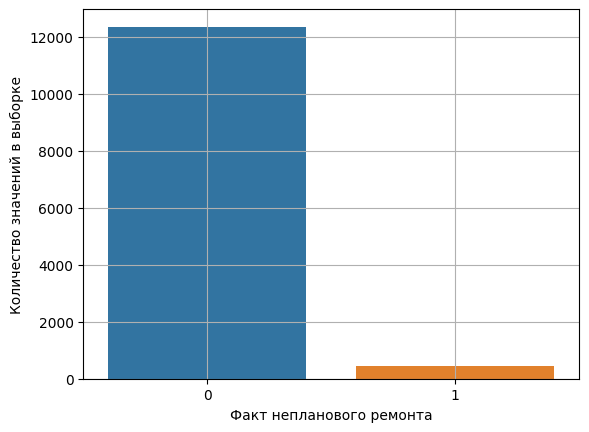

In [31]:
print(df_for_train[label].value_counts())
sns.countplot(df_for_train, x=label)
plt.xlabel("Факт непланового ремонта")
plt.ylabel("Количество значений в выборке")
plt.grid(True)
plt.show()

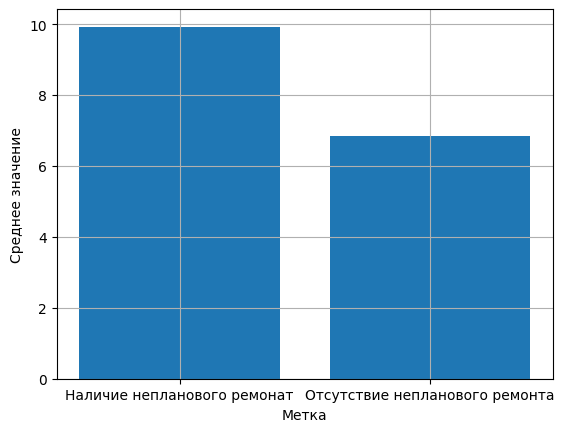

In [32]:
mean_nrs = np.mean(df_for_train[df_for_train.fact_nr == 1].cnt_critic_diag_7d)
mean_without_nrs = np.mean(df_for_train[df_for_train.fact_nr == 0].cnt_critic_diag_7d)

# Отображаем результаты на графике
labels = ['Наличие непланового ремонат', 'Отсутствие непланового ремонта']
means = [mean_nrs, mean_without_nrs]

plt.bar(labels, means)
plt.xlabel('Метка')
plt.ylabel('Среднее значение')
# plt.title('Средние значение количества критических сообщений за 7 дней')
plt.grid(True)
plt.show()

Вывод: в данных наблюдается явная несбалансированность в метках и это потребуется учитывать в обучении

### 3.6. Разделение данных на обучающую и тестовую выборку

In [33]:
train_data, test_data = train_test_split(df_for_train, test_size=0.3)

In [34]:
train_data.columns = cols
test_data.columns = cols

In [35]:
def get_nan_idx(data):
    list_nan_idx = list()
    for col in data.columns:
        idx = data[col].index[data[col].apply(np.isnan)]
        list_nan_idx += list(idx)
    return list_nan_idx

def get_dataset_for_train(train_data, test_data, label_name):
    X_train = train_data[features]
    y_train = train_data[label_name]
    X_test = test_data[features]
    y_test = test_data[label_name]
    # Масштабирование
    scaler = StandardScaler()
    X_train_scl = scaler.fit_transform(X_train[features])
    X_test_scl = scaler.transform(X_test[features])
    X_train_scl = pd.DataFrame(X_train_scl)
    X_test_scl = pd.DataFrame(X_test_scl)
    # Удалениние nan
    list_train_nan_idx = get_nan_idx(X_train_scl)
    list_test_nan_idx = get_nan_idx(X_test_scl)
    X_train_scl = X_train_scl[~X_train_scl.index.isin(list_train_nan_idx)]
    y_train = y_train[~y_train.index.isin(list_train_nan_idx)]
    X_test_scl= X_test_scl[~X_test_scl.index.isin(list_test_nan_idx)]
    y_test = y_test[~y_test.index.isin(list_test_nan_idx)]
    # Именование колонок
    X_train_scl.columns =  features
    X_test_scl.columns = features
    return X_train_scl, X_test_scl, y_train, y_test, scaler

In [39]:
new_columns = []
for name in train_data.columns:
    if ".0" in name:
        name = name.split(".")[0]
    new_columns.append(name)

In [41]:
train_data.columns = new_columns
test_data.columns = new_columns

In [42]:
X_train_scl, X_test_scl, y_train_norm, y_test_norm, scaler = get_dataset_for_train(
    train_data, test_data, label
)

In [43]:
X_train_scl.shape, X_test_scl.shape

((8976, 19), (3848, 19))

## 4. Обучение модели и оценка качества

### 4.1. Обучение модели

In [44]:
weights = compute_class_weight('balanced', classes=np.unique(y_train_norm), y=y_train_norm)

In [45]:
model = CatBoostClassifier(
    iterations=3000,
    depth=4, 
    learning_rate=0.01, 
    task_type="GPU", 
    devices='0:1',
    loss_function='Logloss', 
    eval_metric='AUC',
    class_weights=weights, 
    od_type="Iter", 
    od_wait=300
)

In [47]:
model.fit(
    X_train_scl, 
    y_train_norm,
    eval_set=(X_test_scl, y_test_norm), 
    use_best_model=True, 
    plot=True, 
    metric_period=100,
    verbose=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.6636454	best: 0.6636454 (0)	total: 18.3ms	remaining: 54.8s
100:	test: 0.7986881	best: 0.7986881 (100)	total: 1.9s	remaining: 54.4s
200:	test: 0.8359646	best: 0.8359646 (200)	total: 3.87s	remaining: 53.9s
300:	test: 0.8507677	best: 0.8507677 (300)	total: 6.05s	remaining: 54.3s
400:	test: 0.8604244	best: 0.8604244 (400)	total: 8.13s	remaining: 52.7s
500:	test: 0.8689336	best: 0.8689358 (499)	total: 10.2s	remaining: 50.8s
600:	test: 0.8758485	best: 0.8758485 (600)	total: 12.2s	remaining: 48.7s
700:	test: 0.8800730	best: 0.8803417 (692)	total: 14.1s	remaining: 46.3s
800:	test: 0.8836927	best: 0.8836927 (800)	total: 16.1s	remaining: 44.2s
900:	test: 0.8872866	best: 0.8872866 (900)	total: 18.3s	remaining: 42.6s
1000:	test: 0.8894289	best: 0.8894397 (997)	total: 20.5s	remaining: 40.9s
1100:	test: 0.8919506	best: 0.8919613 (1098)	total: 22.8s	remaining: 39.2s
1200:	test: 0.8943594	best: 0.8944217 (1196)	total: 25s	remaining: 37.5s
1300:	test: 0.8963750	best: 0.8967682 (1288)	total: 

### 4.2. Оценка качества

F1 =  0.20471014492753625
Normalized confusion matrix


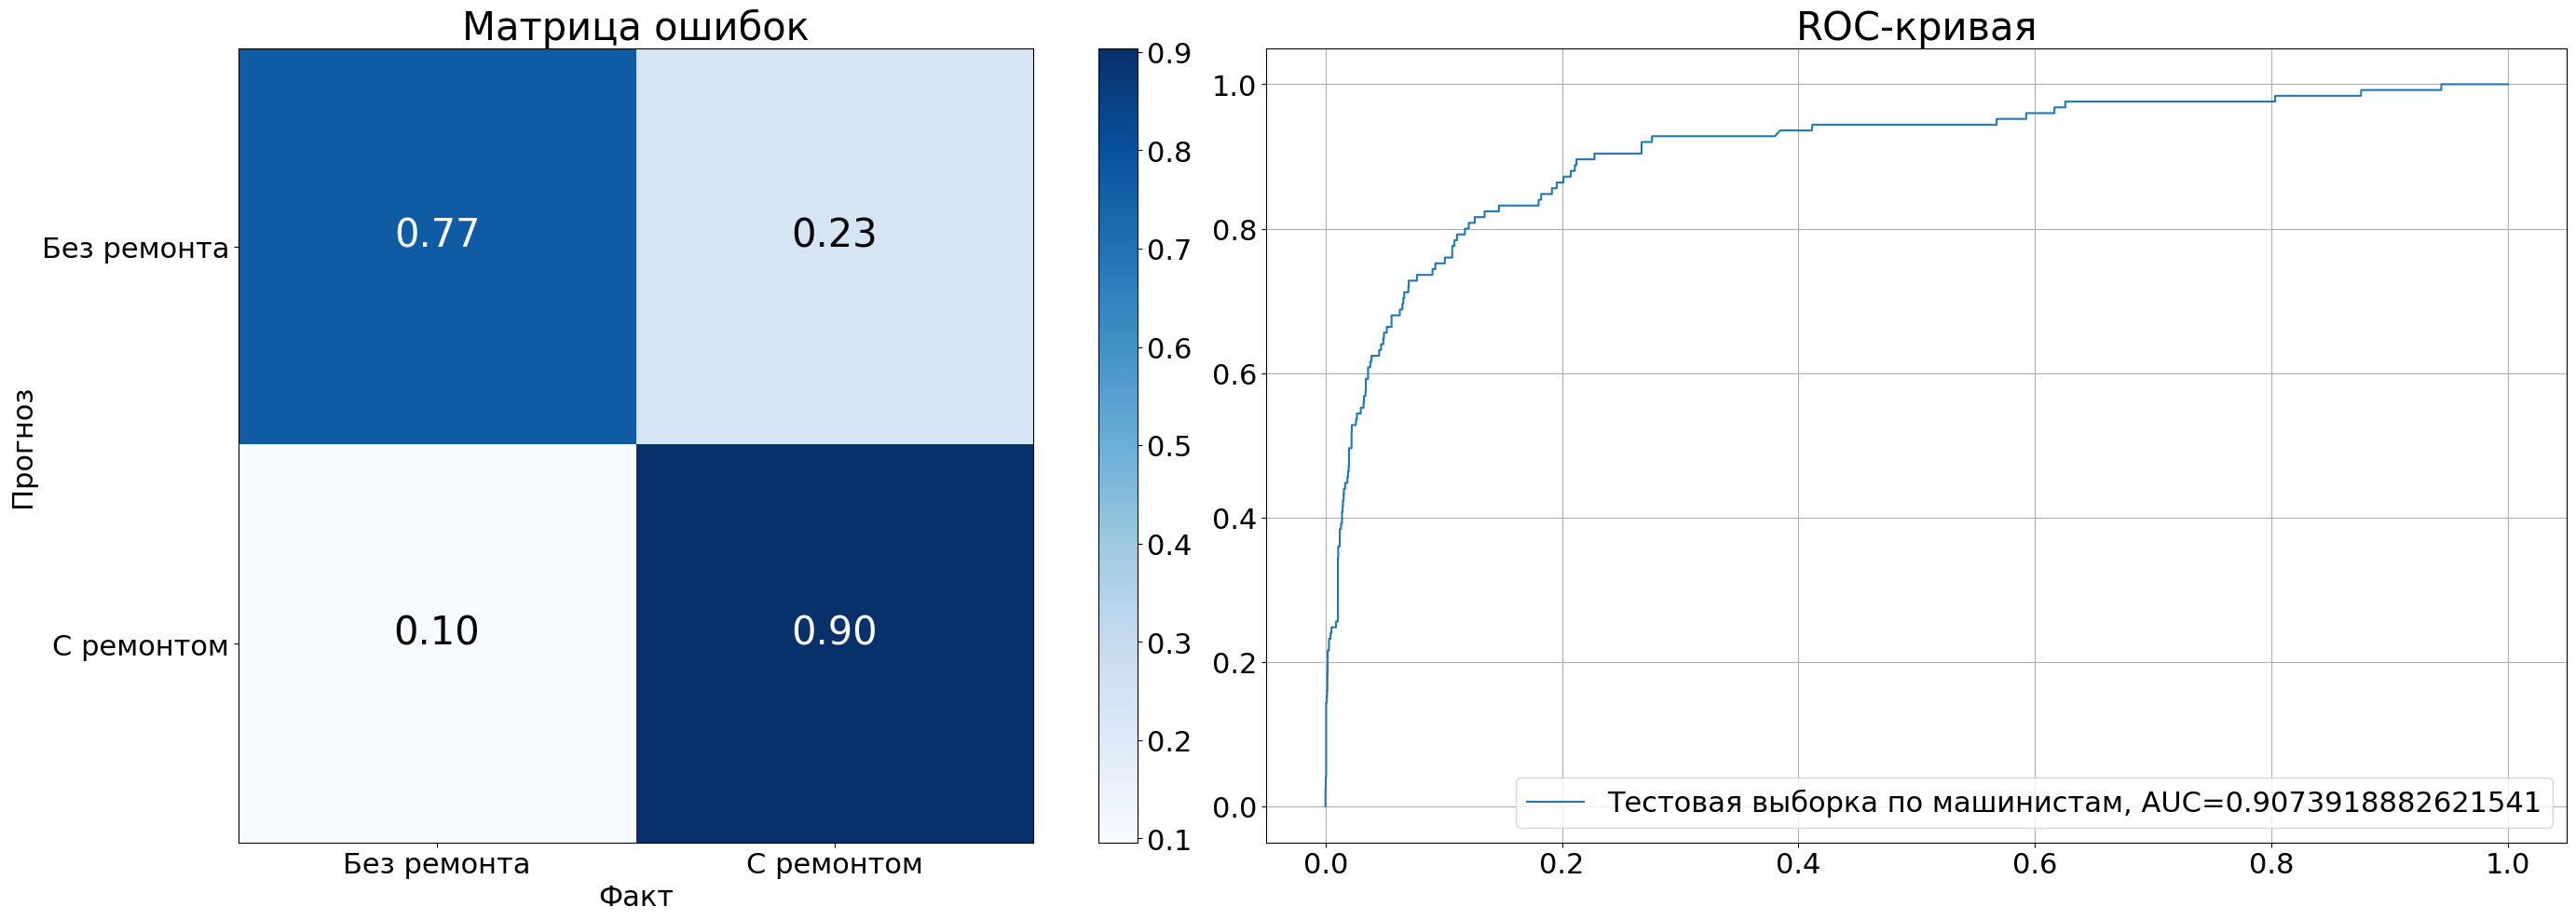

(0.9073918882621541, 0.20471014492753625)

In [48]:
plot_helper.plotTableAUCRoc(model, X_test_scl, y_test_norm, thresholder=0.3, normalize=True)

<Axes: >

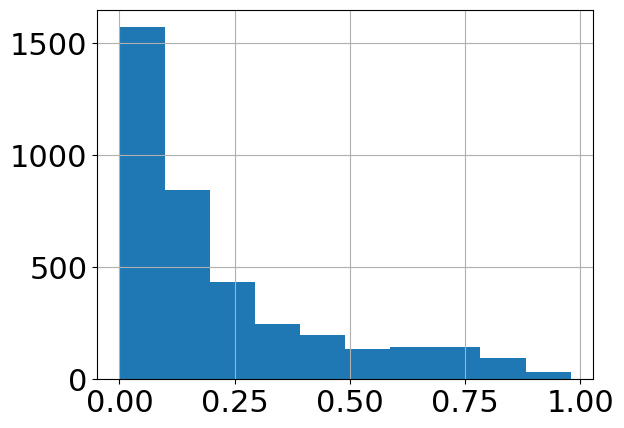

In [49]:
pd.Series(model.predict_proba(X_test_scl)[:, 1]).hist()

Вывод: в результате обучена модель, значение метрики AUC=0.88 на тестовой выборке

In [50]:
model_decision_tree = DecisionTreeClassifier()
model_decision_tree.fit(X_train_scl, y_train_norm)

DecisionTreeClassifier()

F1 =  0.6216216216216216
Normalized confusion matrix


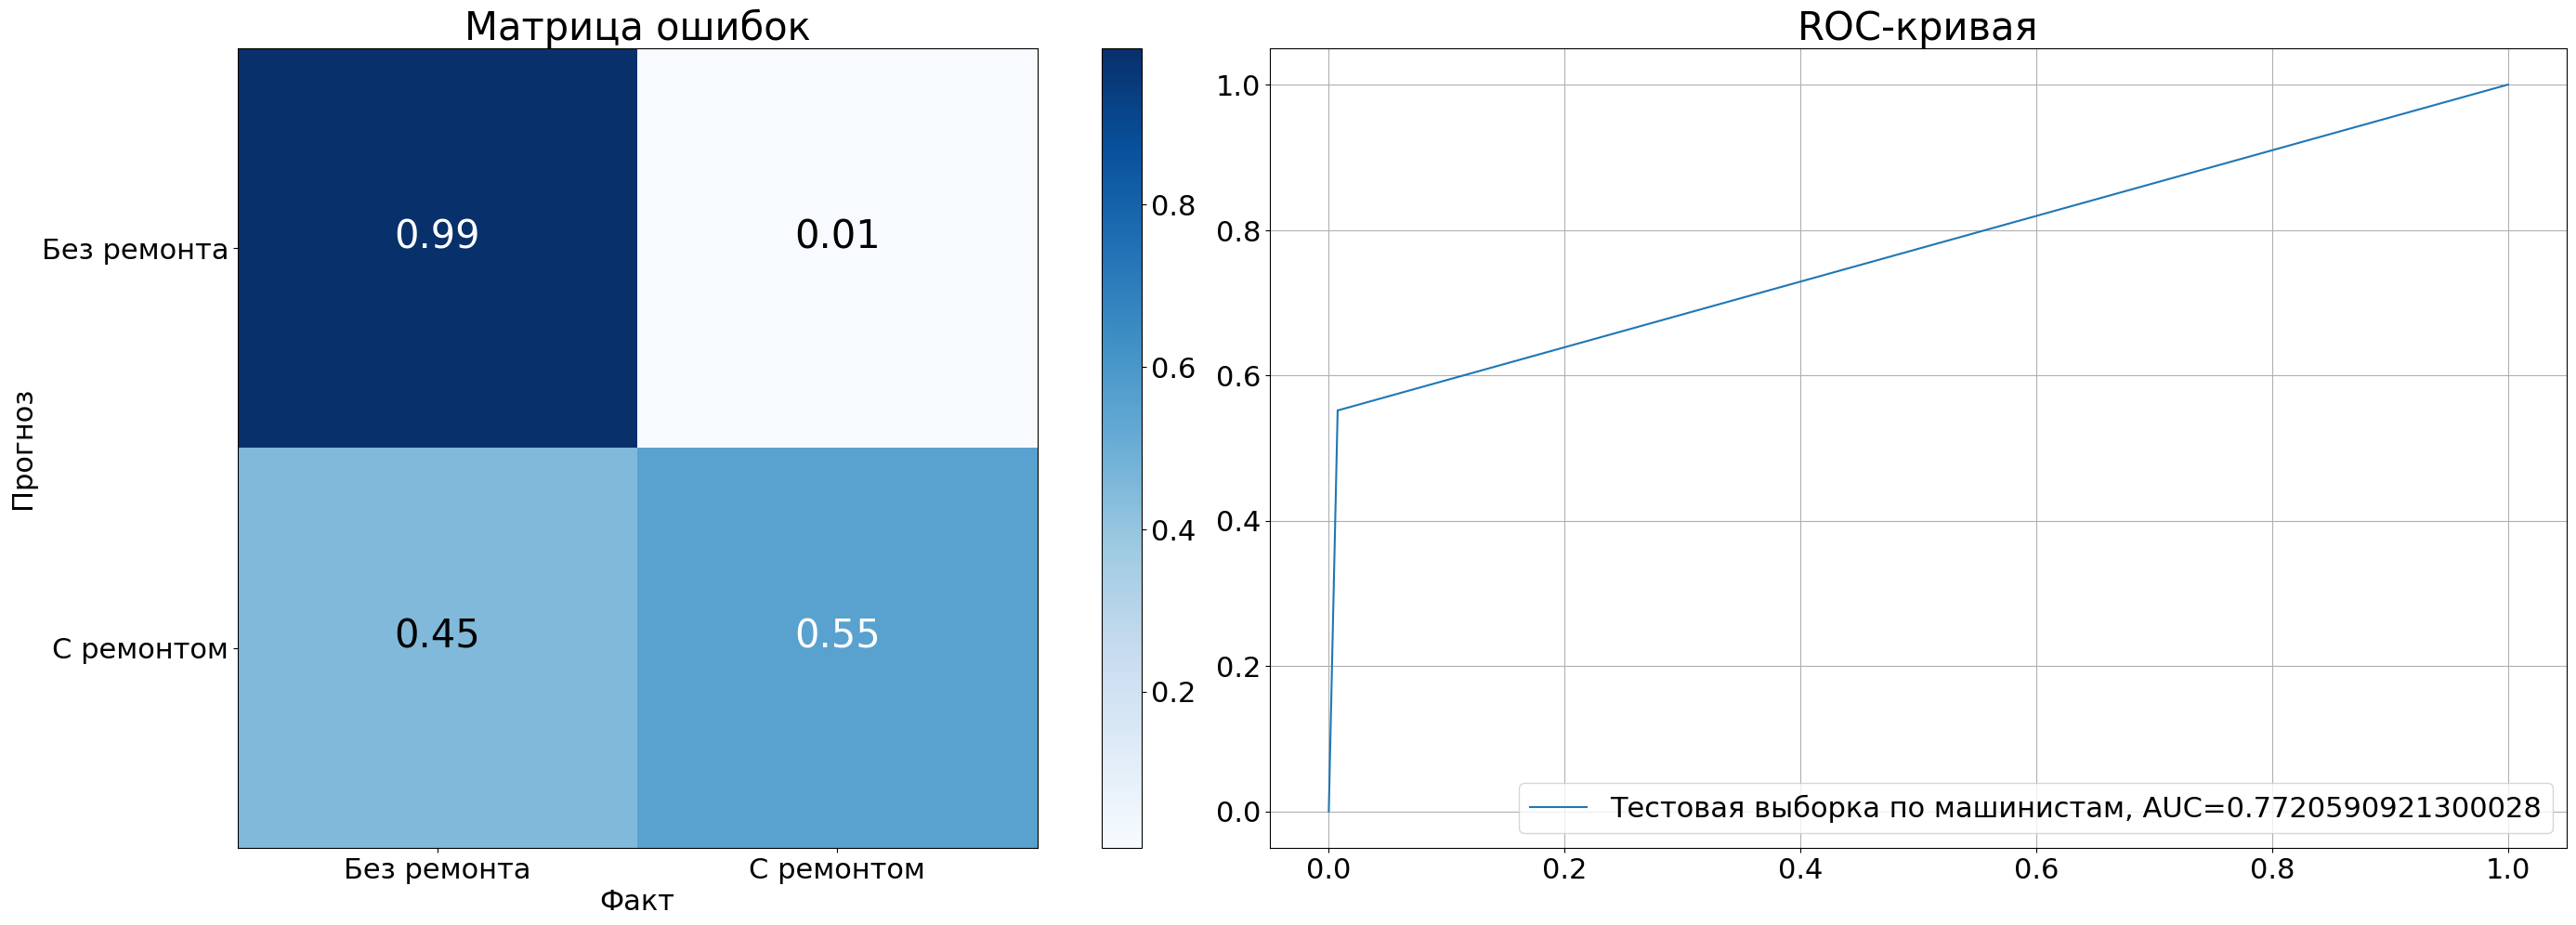

(0.7720590921300028, 0.6216216216216216)

In [51]:
plot_helper.plotTableAUCRoc(model_decision_tree, X_test_scl, y_test_norm, thresholder=0.5, normalize=True)

In [52]:
model_lr = LogisticRegression()
model_lr.fit(X_train_scl, y_train_norm)

LogisticRegression()

F1 =  0.07804878048780488
Normalized confusion matrix


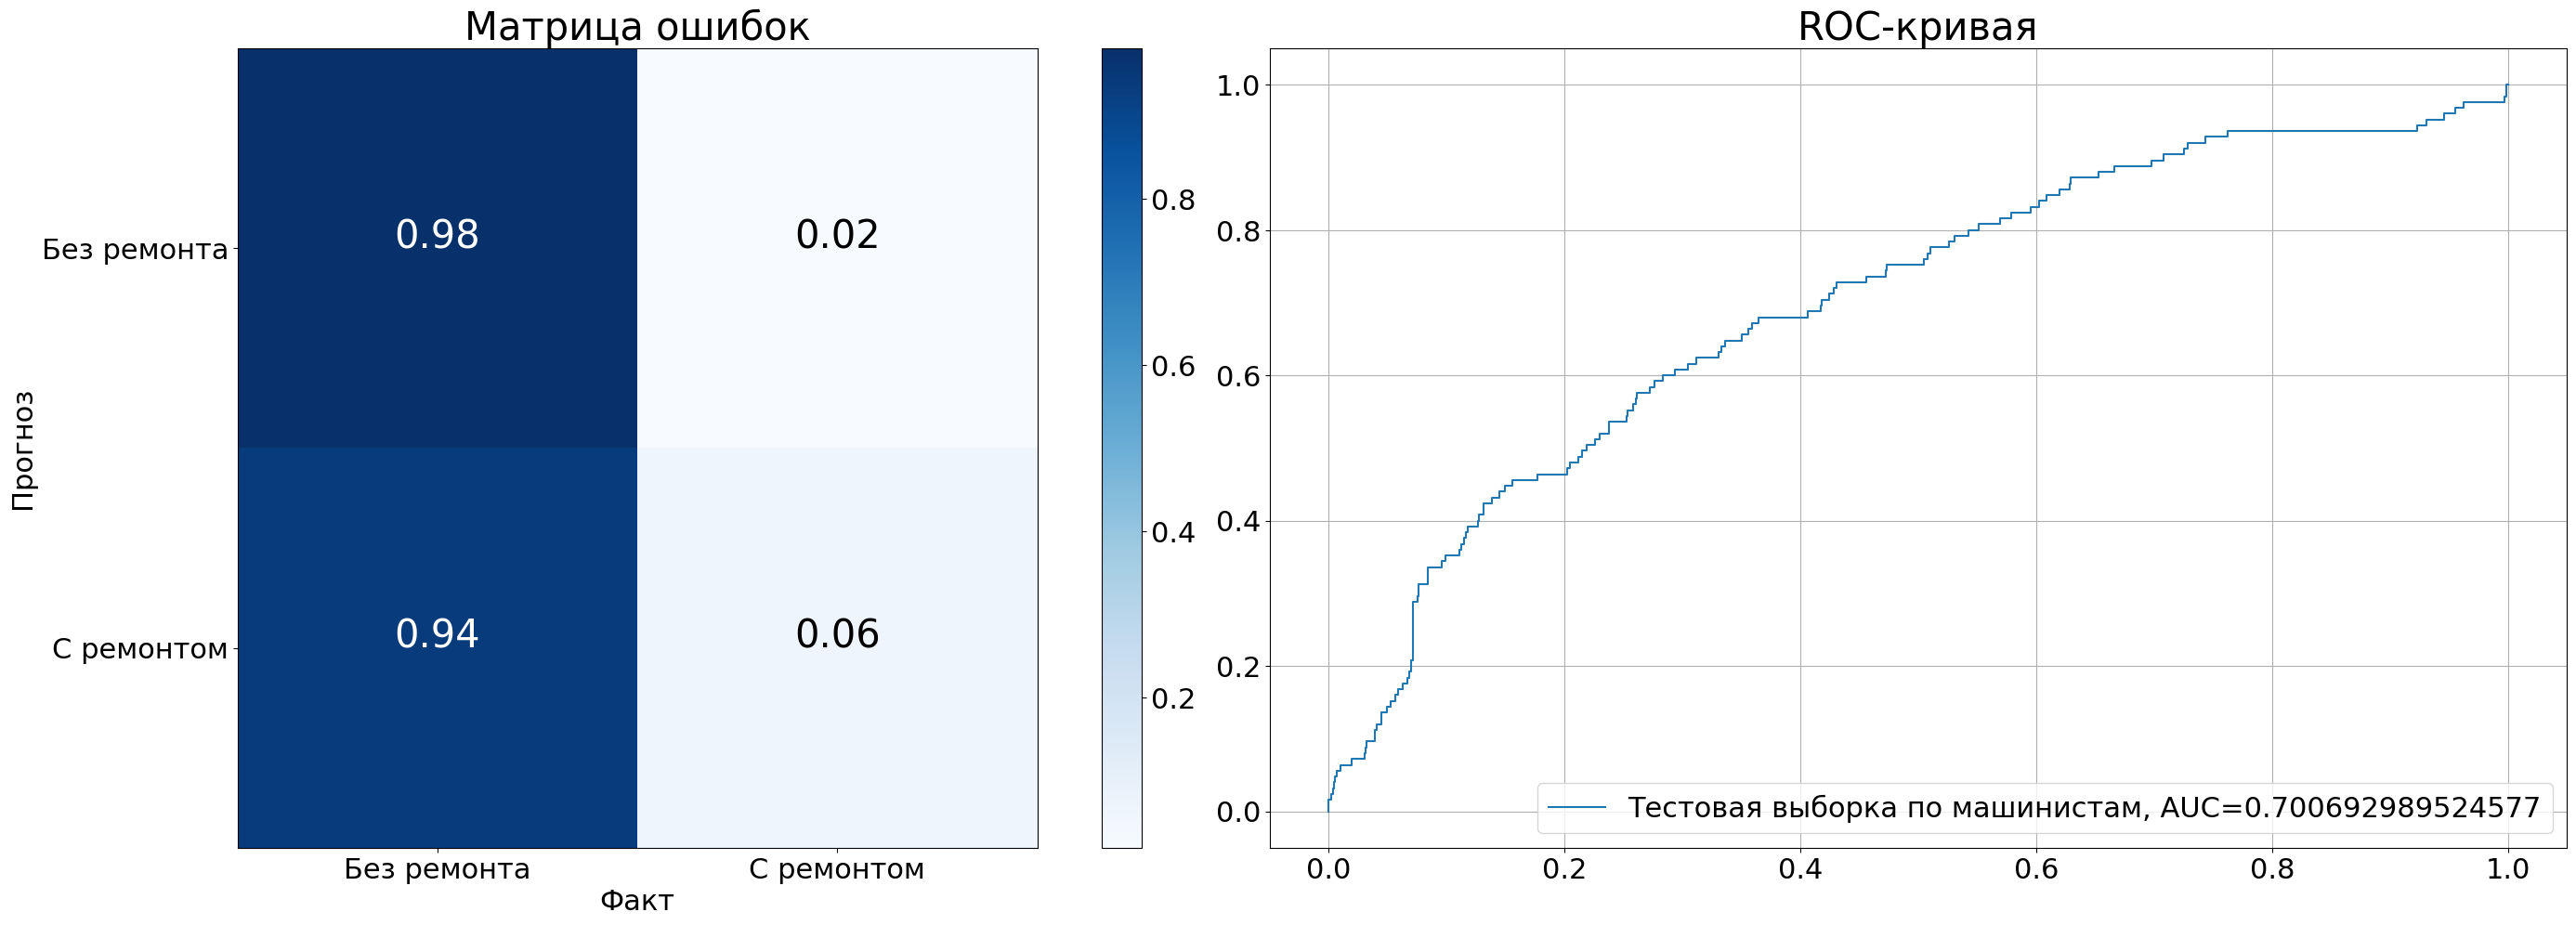

(0.700692989524577, 0.07804878048780488)

In [56]:
plot_helper.plotTableAUCRoc(model_lr, X_test_scl, y_test_norm, thresholder=0.1, normalize=True)

### 4.3. Сохранение модели

In [57]:
model

In [58]:
model.save_model("models/test_model")

In [59]:
model_from_file = CatBoostClassifier()
model_from_file.load_model("models/test_model")

In [60]:
model == model_from_file

True

## 5. Инференс модели

In [61]:
X_test_scl["ser"] = test_data.ser.values
X_test_scl["zns"] = test_data.zns.values
X_test_scl["prs"] = test_data.prs.values
X_test_scl["datetime"] = test_data.datetime.values

In [62]:
X_test_scl["predict"] = model_from_file.predict_proba(X_test_scl[features])[:, 1]

In [63]:
df_warn_loco = X_test_scl[X_test_scl.predict > 0.8].sort_values(by="datetime", ascending=False).head(10)

In [64]:
df_warn_loco[["ser", "zns", "prs", "predict"]].drop_duplicates(subset=["ser", "zns", "prs"])

,ser,zns,prs,predict
854,1878,1113,1,0.800591
770,1878,684,1,0.801465
885,1878,994,0,0.870179
